<a href="https://colab.research.google.com/github/ErmakovSemen/diploma/blob/main/diploma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [211]:
import numpy as np
import pandas as pd
from typing import Dict, List
from scipy.stats import norm
import matplotlib.pyplot as plt

class Assessor:
    def __init__(self, id, bias=0.0, reliability=1.0, tpr=0.8, fpr=0.1):
        self.id = id
        self.bias = bias
        self.reliability = reliability
        self.tpr = tpr  # True Positive Rate
        self.fpr = fpr  # False Positive Rate
        self.history = []

    def rate(self, true_label):
        # Бинарная симуляция ответа (0/1), не используем "bias" здесь — просто задаём по tpr/fpr
        prob = self.tpr if true_label == 1 else self.fpr
        resp = int(np.random.rand() < prob)
        self.history.append(resp)
        return resp

    def p_truth_given_response(self, response, prior=0.5):
        tpr = self.tpr
        fpr = self.fpr

        # Идеальный "детектор" безэмпирически
        if (np.isclose(tpr, 1.0) and np.isclose(fpr, 0.0)):
            return float(response)
        if (np.isclose(tpr, 0.0) and np.isclose(fpr, 1.0)):
            return 1.0 - float(response)

        # Обычный случай (байес)
        if response == 1:
            num = tpr * prior
            denom = tpr * prior + fpr * (1 - prior)
        else:
            num = (1 - tpr) * prior
            denom = (1 - tpr) * prior + (1 - fpr) * (1 - prior)
        if np.isclose(denom, 0):
            return prior
        return num / denom



class DataSimulator:
    def __init__(self, config):
        self.config = config
        self.assessors = self._create_assessors()

    def _create_assessors(self):
        p = self.config["assessors"]
        assessors = []
        for i in range(p["total_count"]):
            tpr = np.clip(np.random.normal(p["tpr_mean"], p["tpr_std"]), 0, 1)
            fpr = np.clip(np.random.normal(p["fpr_mean"], p["fpr_std"]), 0, 1)
            assessors.append(Assessor(i, tpr=tpr, fpr=fpr))
        return assessors

    def simulate_binary_tasks(self):
        group_probs = {
            "A": self.config["experiment"]["prevalence"],
            "B": self.config["experiment"]["prevalence"] + self.config["experiment"]["effect_size"]
        }
        n_tasks = self.config["experiment"]["sample_size"]
        n_assessors = self.config["assessors"]["per_task_count"]
        tasks_by_group = {'A': [], 'B': []}

        n_a = n_tasks // 2
        n_b = n_tasks - n_a
        for group, n in zip(['A', 'B'], [n_a, n_b]):
            for _ in range(n):
                p_true = group_probs[group]
                true_label = int(np.random.rand() < p_true)
                chosen = np.random.choice(self.assessors, size=n_assessors, replace=False)
                responses = [(a.rate(true_label), a.id) for a in chosen]
                tasks_by_group[group].append(responses)
        assessors_by_id = {a.id: a for a in self.assessors}
        return tasks_by_group, assessors_by_id




class AssessorProbabilisticAggregator:
    @staticmethod
    def aggregate_task(responses, assessors_by_id, prior=0.5):
        P_truth = []
        for resp, aid in responses:
            assessor = assessors_by_id[aid]
            p = assessor.p_truth_given_response(resp, prior)
            P_truth.append(p)
        mean_p = np.mean(P_truth)
        var_p = np.mean([p * (1 - p) for p in P_truth]) / (len(P_truth) if len(P_truth) else 1)
        return mean_p, var_p


class VarianceEstimator:
    @staticmethod
    def classic(tasks_by_group, assessors_by_id=None, prior=0.5):
        group_stats = {}
        for group in ['A', 'B']:
            means = [np.mean([label for label, _ in task]) for task in tasks_by_group[group]]
            group_stats[group] = {'mean': np.mean(means), 'var': np.var(means, ddof=1)}
        return {'var_a': group_stats['A']['var'], 'var_b': group_stats['B']['var'],
                'mean_a': group_stats['A']['mean'], 'mean_b': group_stats['B']['mean']}

    @staticmethod
    def probabilistic(tasks_by_group, assessors_by_id, prior=0.5):
        group_stats = {}
        for group in ['A', 'B']:
            means, vars_ = [], []
            for task in tasks_by_group[group]:
                m, v = AssessorProbabilisticAggregator.aggregate_task(task, assessors_by_id, prior)
                means.append(m)
                vars_.append(v)
            mean_group = np.mean(means)
            var_classic = np.var(means, ddof=1)
            var_epistemic = np.sum(vars_) / (len(means) ** 2)
            var_total = var_classic + var_epistemic  # <-- ключевой момент
            group_stats[group] = {'mean': mean_group, 'var': var_total}
        return {'var_a': group_stats['A']['var'], 'var_b': group_stats['B']['var'],
                'mean_a': group_stats['A']['mean'], 'mean_b': group_stats['B']['mean']}


In [212]:
def generate_assessors(n=200, bias_mean=0.0, bias_std=0.3):
    assessors = []
    for i in range(n):
        bias = np.random.normal(bias_mean, bias_std)
        reliability = np.clip(np.random.beta(2, 5), 0.1, 0.99)
        tpr = np.clip(np.random.normal(0.8, 0.07), 0.5, 0.99)
        fpr = np.clip(np.random.normal(0.1, 0.05), 0.01, 0.45)
        assessor = Assessor(id=i, bias=bias, reliability=reliability, tpr=tpr, fpr=fpr)
        assessors.append(assessor)
    return assessors


In [213]:
from sklearn.metrics import f1_score

def get_f1_from_results(df_results, method):
    mdata = df_results[(df_results['method'] == method) & (df_results['status'] == 'success')]
    if len(mdata) < 1:
        return None
    y_true = mdata['true_effect'].astype(int).values
    y_pred = mdata['effect_detected'].fillna(False).astype(int).values
    if len(np.unique(y_true)) < 2 or len(np.unique(y_pred)) < 1:
        return None
    return f1_score(y_true, y_pred, zero_division=0)


In [214]:
def run_exp(config, n_simulations=100, prior=0.5, alpha=None, methods=None):
    """
    Запуск симуляций эксперимента с F1-score теста для каждого метода.
    """
    import pandas as pd
    from scipy.stats import norm

    if alpha is None:
        alpha = config["experiment"].get("alpha", 0.05)

    if methods is None:
        methods = {
            "classic": VarianceEstimator.classic,
            "probabilistic": lambda tasks_by_group, assessors_by_id, prior:
                VarianceEstimator.probabilistic(tasks_by_group, assessors_by_id, prior)
        }

    results = []
    for sim in range(n_simulations):
        has_effect = np.random.rand() > 0.5
        effect_size = config["experiment"]["effect_size"] if has_effect else 0.0

        local_config = {**config, "experiment": {**config["experiment"], "effect_size": effect_size}}

        simulator = DataSimulator(local_config)
        tasks_by_group, assessors_by_id = simulator.simulate_binary_tasks()

        if len(tasks_by_group['A']) < 2 or len(tasks_by_group['B']) < 2:
            continue

        for method_name, method in methods.items():
            try:
                res = method(tasks_by_group, assessors_by_id, prior)
                n_a, n_b = len(tasks_by_group['A']), len(tasks_by_group['B'])
                var_ztest = res['var_a'] / n_a + res['var_b'] / n_b
                se = np.sqrt(var_ztest)
                effect = res['mean_b'] - res['mean_a']
                if se == 0:
                    p_value = 1.0 if effect == 0 else 0.0
                else:
                    z_score = effect / se
                    p_value = 2 * (1 - norm.cdf(abs(z_score)))
                results.append({
                    "simulation": sim,
                    "method": method_name,
                    "p_value": p_value,
                    "effect_detected": (p_value < alpha) if p_value is not None else None,
                    "true_effect": has_effect,
                    "mean_diff": effect,
                    "var_a": res['var_a'],
                    "var_b": res['var_b'],
                    "var_ztest": var_ztest,
                    "status": "success"
                })
            except Exception as e:
                results.append({
                    "simulation": sim,
                    "method": method_name,
                    "p_value": None,
                    "effect_detected": None,
                    "true_effect": has_effect,
                    "mean_diff": None,
                    "var_a": None,
                    "var_b": None,
                    "var_ztest": None,
                    "status": f"failed: {e}"
                })

    df_results = pd.DataFrame(results)
    summary = {}
    for method in methods.keys():
        mdata = df_results[(df_results['method'] == method) & (df_results['status'] == 'success')]
        if len(mdata) < 1:
            summary[method] = {
                "power": None,
                "fpr": None,
                "success_rate": 0,
                "mean_effect": None,
                "f1_test": None
            }
            continue
        has_true = (mdata['true_effect'] == True).sum() > 0
        has_false = (mdata['true_effect'] == False).sum() > 0
        power = mdata[mdata['true_effect'] == True]['effect_detected'].mean() if has_true else None
        fpr = mdata[mdata['true_effect'] == False]['effect_detected'].mean() if has_false else None
        f1_test = get_f1_from_results(df_results, method)
        summary[method] = {
            "power": power,
            "fpr": fpr,
            "success_rate": len(mdata) / n_simulations,
            "mean_effect": mdata['mean_diff'].mean() if mdata['mean_diff'].notna().any() else None,
            "f1_test": f1_test
        }
    return df_results, summary


In [215]:
def plot_results(summary: Dict, config=None):
    """Визуализация сводных результатов, включая F1-score теста"""
    methods = list(summary.keys())

    fig, ax = plt.subplots(1, 4, figsize=(24, 5))  # Теперь четыре фигуры

    # Мощность теста
    ax[0].bar(methods, [summary[m]["power"] for m in methods], color='skyblue')
    ax[0].set_title("Мощность теста (Power)")
    ax[0].set_ylim(0, 1)

    # False Positive Rate
    ax[1].bar(methods, [summary[m]["fpr"] for m in methods], color='salmon')
    ax[1].set_title("False Positive Rate")
    ax[1].axhline(0.05, color='red', linestyle='--')
    ax[1].set_ylim(0, 0.2)

    # Обнаруженный эффект
    ax[2].bar(methods, [summary[m]["mean_effect"] for m in methods], color='lightgreen')
    ax[2].set_title("Средний обнаруженный эффект")
    if config:
        ax[2].axhline(config["experiment"]["effect_size"]/2, color='gray', linestyle='--')

    # F1-score теста
    ax[3].bar(methods, [summary[m]["f1_test"] for m in methods], color='violet')
    ax[3].set_title("F1-score теста")
    ax[3].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()


In [221]:
def config_fpr():
    return {
        "experiment": {
            "sample_size": 200,
            "groups": ["A", "B"],
            "alpha": 0.05,
            "prevalence": 0.25,
            "effect_size": 0.0
        },
        "assessors": {
            "total_count": 40,
            "per_task_count": 12,
            "tpr_mean": 0.8,
            "tpr_std": 0.03,
            "fpr_mean": 0.2,
            "fpr_std": 0.03
        }
    }

def config_power():
    return {
        "experiment": {
            "sample_size": 2000,  # по 1000 на каждую группу
            "groups": ["A", "B"],
            "alpha": 0.05,
            "prevalence": 0.25,
            "effect_size": 0.15    # заметная разница между группами
        },
        "assessors": {
            "total_count": 60,     # больше оценщиков — стабильней средние!
            "per_task_count": 12,
            "tpr_mean": 0.82,      # хорошие, но не идеальные люди
            "tpr_std": 0.03,
            "fpr_mean": 0.18,
            "fpr_std": 0.03
        }
    }


def config_ideal():
    return {
        "experiment": {
            "sample_size": 200,
            "groups": ["A", "B"],
            "alpha": 0.05,
            "prevalence": 0.22,
            "effect_size": 0.10
        },
        "assessors": {
            "total_count": 40,
            "per_task_count": 12,
            "tpr_mean": 1.0,
            "tpr_std": 0.0,
            "fpr_mean": 0.0,
            "fpr_std": 0.0
        }
    }

def config_hard():
    return {
        "experiment": {
            "sample_size": 600,
            "groups": ["A", "B"],
            "alpha": 0.05,
            "prevalence": 0.08,
            "effect_size": 0.03
        },
        "assessors": {
            "total_count": 60,
            "per_task_count": 10,
            "tpr_mean": 0.7,
            "tpr_std": 0.03,
            "fpr_mean": 0.3,
            "fpr_std": 0.03
        }
    }

EXPERIMENT_CONFIGS = {
    'fpr':        config_fpr,
    'power':      config_power,
    'ideal':      config_ideal,
    'hard':       config_hard,
}

# --- Использование:
# config = EXPERIMENT_CONFIGS['fpr']()
# df_results, summary = run_exp(config, n_simulations=500)



Сводные результаты:
CLASSIC         Power: 0.071 | FPR: 0.045 | Effect: -0.000
PROBABILISTIC   Power: 0.067 | FPR: 0.043 | Effect: -0.000


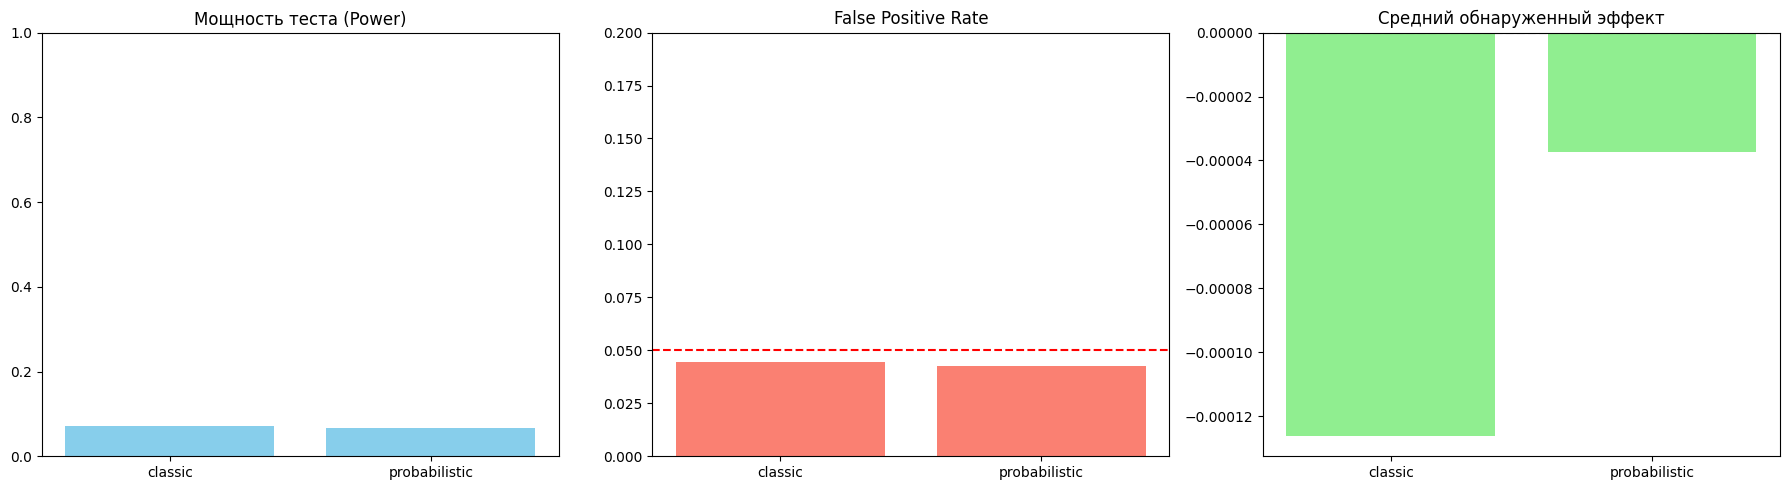

In [197]:

# Пример использования
if __name__ == "__main__":
    config = EXPERIMENT_CONFIGS['fpr']()






    # Запуск эксперимента
    df_results, summary = run_exp(config, n_simulations=1000)

    # Вывод сводки
    print("\nСводные результаты:")
    for method, stats in summary.items():
        power      = f"{stats['power']:.3f}"      if stats['power'] is not None else "---"
        fpr        = f"{stats['fpr']:.3f}"        if stats['fpr'] is not None else "---"
        mean_eff   = f"{stats['mean_effect']:.3f}"if stats['mean_effect'] is not None else "---"
        print(f"{method.upper():<15} Power: {power} | FPR: {fpr} | Effect: {mean_eff}")

    # Визуализация
    plot_results(summary)


Сводные результаты:
CLASSIC         Power: 0.309 | FPR: 0.050 | Effect: 0.050 | f1: 0.456
PROBABILISTIC   Power: 0.309 | FPR: 0.050 | Effect: 0.050 | f1: 0.456


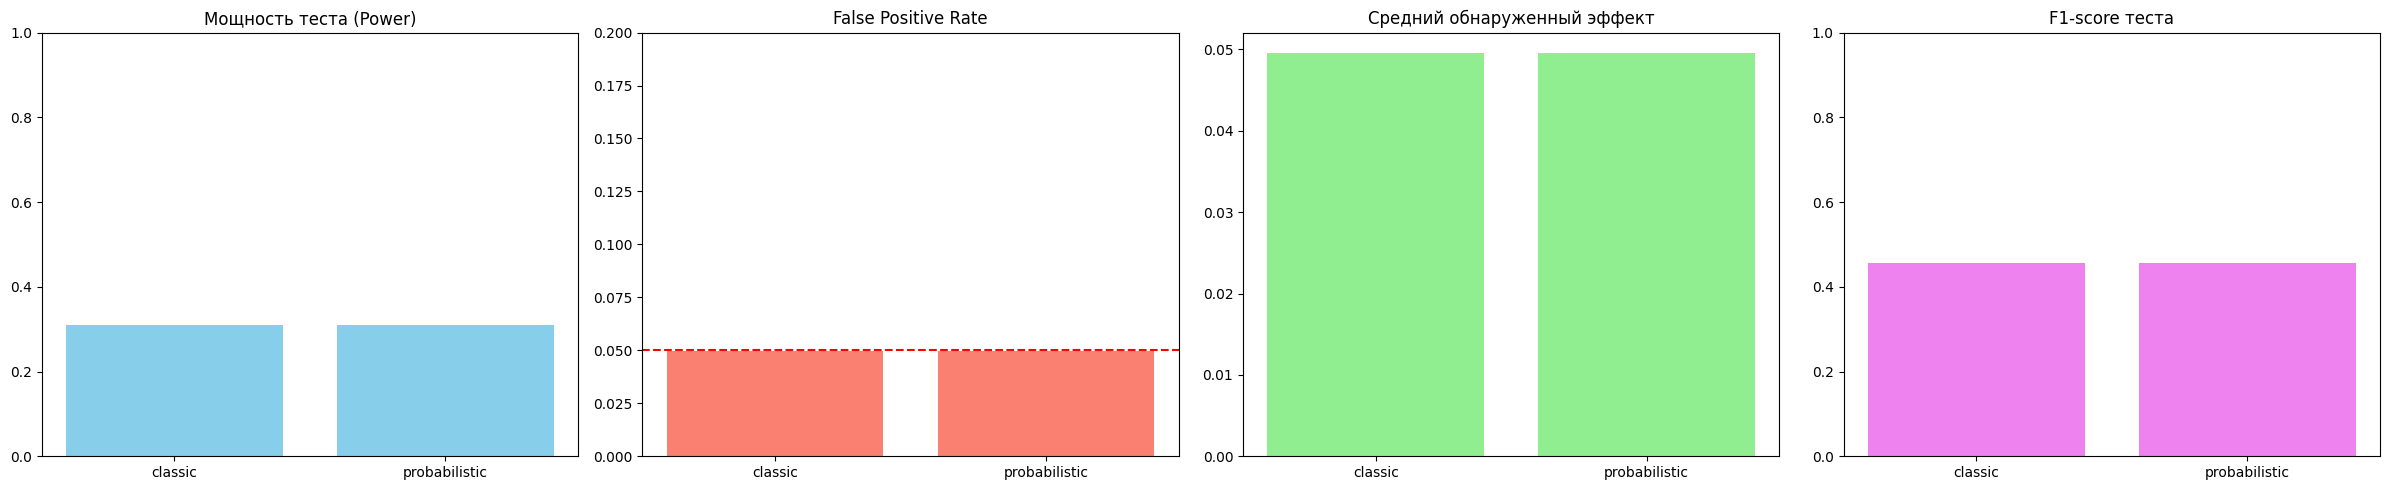

In [219]:
if __name__ == "__main__":
    config = EXPERIMENT_CONFIGS['ideal']()






    # Запуск эксперимента
    df_results, summary = run_exp(config, n_simulations=500)

    # Вывод сводки
    print("\nСводные результаты:")
    for method, stats in summary.items():
        power      = f"{stats['power']:.3f}"      if stats['power'] is not None else "---"
        fpr        = f"{stats['fpr']:.3f}"        if stats['fpr'] is not None else "---"
        mean_eff   = f"{stats['mean_effect']:.3f}"if stats['mean_effect'] is not None else "---"
        f1   = f"{stats['f1_test']:.3f}"if stats['f1_test'] is not None else "---"
        print(f"{method.upper():<15} Power: {power} | FPR: {fpr} | Effect: {mean_eff} | f1: {f1}")

    # Визуализация
    plot_results(summary)

In [210]:
# ТУТ ЛАЖА!!!

In [218]:
df_results

,simulation,method,p_value,effect_detected,true_effect,mean_diff,var_a,var_b,var_ztest,status
0,0,classic,0.538749,False,True,0.04,0.203636,0.219798,0.004234,success
1,0,probabilistic,0.538749,False,True,0.04,0.203636,0.219798,0.004234,success
2,1,classic,0.006361,True,True,0.17,0.155455,0.232727,0.003882,success
3,1,probabilistic,0.006361,True,True,0.17,0.155455,0.232727,0.003882,success
4,2,classic,0.140739,False,False,0.08,0.121616,0.173333,0.002949,success
...,...,...,...,...,...,...,...,...,...,...
195,97,probabilistic,0.076260,False,False,-0.10,0.189394,0.128788,0.003182,success
196,98,classic,0.481157,False,True,0.04,0.149091,0.173333,0.003224,success
197,98,probabilistic,0.481157,False,True,0.04,0.149091,0.173333,0.003224,success
198,99,classic,0.015243,True,True,0.15,0.155455,0.226667,0.003821,success



Сводные результаты:
CLASSIC         Power: 1.000 | FPR: 0.034 | Effect: 0.050 | f1: 0.984
PROBABILISTIC   Power: 1.000 | FPR: 0.034 | Effect: 0.032 | f1: 0.984


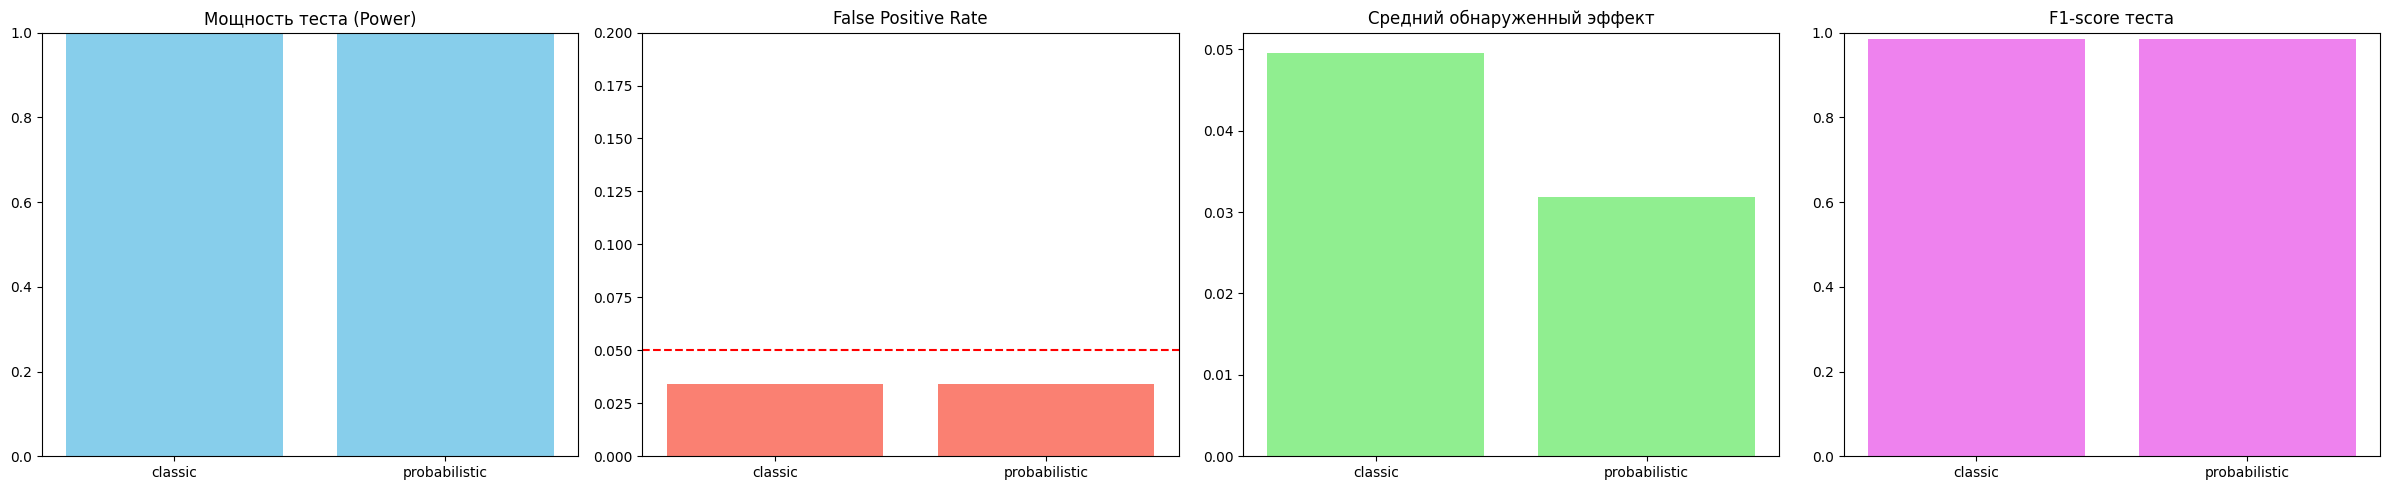

In [222]:
if __name__ == "__main__":
    config = EXPERIMENT_CONFIGS['power']()






    # Запуск эксперимента
    df_results, summary = run_exp(config, n_simulations=300)

    # Вывод сводки
    print("\nСводные результаты:")
    for method, stats in summary.items():
        power      = f"{stats['power']:.3f}"      if stats['power'] is not None else "---"
        fpr        = f"{stats['fpr']:.3f}"        if stats['fpr'] is not None else "---"
        mean_eff   = f"{stats['mean_effect']:.3f}"if stats['mean_effect'] is not None else "---"
        f1   = f"{stats['f1_test']:.3f}"if stats['f1_test'] is not None else "---"
        print(f"{method.upper():<15} Power: {power} | FPR: {fpr} | Effect: {mean_eff} | f1: {f1}")

    # Визуализация
    plot_results(summary)